### Loading dataset from CICDDoS2019 and balancing it. Plus, Scaling data points and splitting data

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("CICDDoS2019_Syn.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

# Create a RandomUnderSampler object
under_sampler = RandomUnderSampler(sampling_strategy={'Syn': 35790}, random_state=42)

# Split the features (X) and the target (y)
X = df.drop('Label', axis=1)  # Replace with your actual feature columns
y = df['Label']

# Perform undersampling
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
df = pd.DataFrame(X_resampled, columns=X.columns)
df['Label'] = y_resampled
# Now df_resampled contains a balanced dataset

df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify=y)

C:\Users\dyari\AppData\Local\Temp\ipykernel_19204\3247416133.py:8: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICDDoS2019_Syn.csv")
C:\Users\dyari\AppData\Local\Temp\ipykernel_19204\3247416133.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_19204\3247416133.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=100,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.26282998
Iteration 2, loss = 0.22516002
Iteration 3, loss = 0.21881808
Iteration 4, loss = 0.21629389
Iteration 5, loss = 0.20873939
Iteration 6, loss = 0.20202317
Iteration 7, loss = 0.18980941
Iteration 8, loss = 0.15676599
Iteration 9, loss = 0.13531817
Iteration 10, loss = 0.11921841
Iteration 11, loss = 0.12983072
Iteration 12, loss = 0.11891635
Iteration 13, loss = 0.11926379
Iteration 14, loss = 0.12407966
Iteration 15, loss = 0.13089075
Iteration 16, loss = 0.11822539
Iteration 17, loss = 0.12007628
Iteration 18, loss = 0.11905241
Iteration 19, loss = 0.11978497
Iteration 20, loss = 0.11882231
Iteration 21, loss = 0.12209145
Iteration 22, loss = 0.11789842
Iteration 23, loss = 0.11633473
Iteration 24, loss = 0.11602737
Iteration 25, loss = 0.11596880
Iteration 26, loss = 0.14687907
Iteration 27, loss = 0.11952474
Iteration 28, loss = 0.11882594
Iteration 29, loss = 0.11305303
Iteration 30, loss = 0.11383952
Iteration 31, loss = 0.11381966
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.954177144453758
---------------------------------------------------------


array([[6936,  222],
       [ 434, 6724]], dtype=int64)

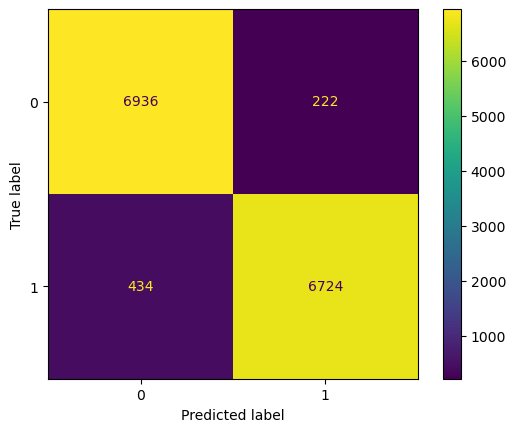

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.5001397038278849
---------------------------------------------------------


array([[7158,    0],
       [7156,    2]], dtype=int64)

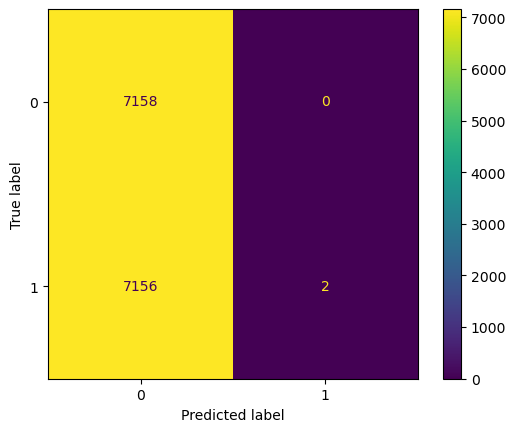

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)

print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))
print("---------------------------------------------------------")


Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix